# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started

# **Prédire quels Tweets sont liés à des catastrophes naturelles réelles et quels Tweets ne le sont pas.**

## Importation des librairies.

In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np



from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Activation, SimpleRNN,Dense

In [ ]:
dataset = pd.read_csv("train(1).csv")
dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Nouvelle section

# Nouvelle section

# Nouvelle section

In [ ]:
dataset.shape

(7613, 5)

In [ ]:
dataset0 = dataset

In [ ]:
pd.unique(dataset0.target)

array([1, 0])

In [ ]:
dataset0.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


## Regarder les doublons.

In [ ]:
# Il est indiqué dans discribe que le nombre unique de la colonne 'text' est inférieur au nombre total. 
# Cela signifie que nous pourrions avoir des données en double qui doivent être supprimées pour de meilleurs résultats d'entraînement. 
# il y a des doublons qui ont le même texte et la même cible.

duplicates = dataset0[dataset.duplicated(['text', 'target'], keep=False)]
print(f'Train Duplicate Entries (text, target): {len(duplicates)}')
duplicates.head()

Train Duplicate Entries (text, target): 157


,id,keyword,location,text,target
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
118,171,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0


## Supression des doublons.

In [ ]:
dataset0.drop_duplicates(['text', 'target'], inplace=True, ignore_index=True)
print(dataset0.shape)

(7521, 5)


## Nous avons trouvé dans le corpus des doublons avec des cibles différentes.

In [ ]:
# Les doublons avec le même mot-clé et le même texte partagent les deux classes cibles. Le nombre est suffisamment faible pour examiner manuellement 
# ces tweets et supprimer ceux dont l'étiquette cible est incorrecte.

new_duplicates = dataset0[dataset0.duplicated(['keyword', 'text'], keep=False)]

print(f'Train Duplicate Entries (keyword, text): {len(new_duplicates)}')
new_duplicates[['text', 'target']].sort_values(by='text')

Train Duplicate Entries (keyword, text): 30


,text,target
4238,#Allah describes piling up #wealth thinking it...,0
4253,#Allah describes piling up #wealth thinking it...,1
4171,#foodscare #offers2go #NestleIndia slips into ...,1
4193,#foodscare #offers2go #NestleIndia slips into ...,0
2802,.POTUS #StrategicPatience is a strategy for #G...,1
2803,.POTUS #StrategicPatience is a strategy for #G...,0
4554,CLEARED:incident with injury:I-495 inner loop...,0
4535,CLEARED:incident with injury:I-495 inner loop...,1
4182,Caution: breathing may be hazardous to your he...,1
4185,Caution: breathing may be hazardous to your he...,0


### Nous avons 30 textes qui sont identiques qu'on peut trier manuelement.

In [ ]:
# Supprimer les 15 targets qui sont fausses pour chaque paire de doublons.

dataset0.drop([4253, 4193, 2802, 4554, 4182, 3212, 4249, 4259, 6535, 4319, 4239, 606, 3936, 6018, 5573], inplace=True)

In [ ]:
# Réinitialisation de l'index du dataframe pour tenir compte des numéros manquants

dataset0 = dataset0.reset_index(drop=True)
dataset0

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7501,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7502,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7503,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7504,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


# On verifie s'il n'y a pas de valeurs manquantes dans 'text' et 'target'.

In [ ]:
dataset0.isna().sum()

id             0
keyword       56
location    2483
text           0
target         0
dtype: int64

# Nous avons une bonne répatition de notre variable cible.

In [ ]:
dataset0.target.value_counts(normalize=True)

0    0.574474
1    0.425526
Name: target, dtype: float64

# Nous observons dans cet exemple que sur la ligne 69 du texte reste des liens http, des majuscules, des caratères spéciaux et des chiffres que nous devrons supprimer.

In [ ]:
exam = dataset0.iloc[68,3]
exam

'Accident center lane blocked in #SantaClara on US-101 NB before Great America Pkwy #BayArea #Traffic http://t.co/pmlOhZuRWR'

# Création d'une nouvelle variable dataset_copie.

In [ ]:
dataset_copy = dataset0
dataset_copy

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7501,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7502,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7503,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7504,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


In [ ]:
# Supression des lien HTTP qui n'apporteront rien à nos predictions

dataset_copy['text'] = dataset_copy['text'].map(lambda x: re.sub(r'http\S+', '',x))

In [ ]:
# suprimer les chiffres dans le texte

dataset_copy['text'] = dataset_copy['text'].str.replace("\d+", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The default value of regex will change from True to False in a future version.



## Verification de notre premier nettoyage de la ligne 68.

In [ ]:
test = dataset_copy.iloc[68,3]
test

'Accident center lane blocked in #SantaClara on US- NB before Great America Pkwy #BayArea #Traffic '

## Sélection des colonnes qui nous intéressent.

In [ ]:
dataset1 = dataset_copy[["text", "target"]]
dataset1.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,", people receive #wildfires evacuation orders ...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## Import de la librairie pour la lemmatisation.

In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

## Import de la librairie pour enlever les stop_words de la langue anglaise.

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS

### Créer une fonction pour garder toutes les chaines de caractères qui ne sont pas alpha numeriques, rempacer les doubles espace par simple espace et les majiscules par les minuscules puis remplacer l'intégralité de mes token par des lemma et enlever les stop_words. 

In [ ]:
def clean_text(text):
  text = "".join([ch for ch in text if ch.isalnum() or ch == " "])
  text = re.sub(" +", " ", text).lower().strip()
  text = " ".join([token.lemma_ for token in nlp(text) if token.text not in STOP_WORDS and token.lemma_ not in STOP_WORDS])
  return text     # pour chaque token dans nlp appliqué a la colonne text je vais chercher les lemmas mais uniquement si le text associer a mes tokens 
                  # n'es pas ds les stop_word et que le lemma associer a mon token n'es pas ds les stop_word

## Appliquer la fonction à l'intégralité de mes corpus de texte sur ma colonne text en créant une nouvelle colonne 'text_clean'.

In [ ]:
dataset1["text_clean"] = dataset1["text"].apply(lambda x: clean_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
dataset1

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,", people receive #wildfires evacuation orders ...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school
...,...,...,...
7501,#WorldNews Fallen powerlines on G:link tram: U...,1,worldnews fall powerline glink tram update fir...
7502,on the flip side I'm at Walmart and there is a...,1,flip walmart bomb evacuate stay tune blow
7503,Suicide bomber kills in Saudi security site m...,1,suicide bomber kill saudi security site mosque...
7504,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home


## Vérification de mon nettoyage avec un élement de 'text_clean'.

In [ ]:
exemp = dataset1.iloc[68,2]
exemp

'accident center lane block santaclara nb great america pkwy bayarea traffic'

## Remplacement de mes mots par des indices.

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)  # garder les 1000 mots les plus frequent
tokenizer.fit_on_texts(dataset1.text_clean)
dataset1["review_encoded"] = tokenizer.texts_to_sequences(dataset1.text_clean) # création d'une new colonne indice 'review_encoded'


dataset1["len_review"] = dataset1["review_encoded"].apply(lambda x: len(x)) # création d'un new colonne 'len_review' la longueur de nos séquence
dataset1 = dataset1[dataset1["len_review"]!=0]                              # supprimer les lignes d'on les indices a '0' (certaine de nos review ont que des "stop_words")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
len(tokenizer.index_word)

15093

In [ ]:
dataset1


,text,target,text_clean,review_encoded,len_review
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[393, 164]",2
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[106, 2, 155, 472, 925]",5
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[425, 312, 275, 191, 312, 300, 360]",7
3,", people receive #wildfires evacuation orders ...",1,people receive wildfire evacuation order calif...,"[6, 65, 191, 300, 34]",5
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school,"[165, 112, 160, 65, 100]",5
...,...,...,...,...,...
7501,#WorldNews Fallen powerlines on G:link tram: U...,1,worldnews fall powerline glink tram update fir...,"[79, 166, 2, 487, 78, 799]",6
7502,on the flip side I'm at Walmart and there is a...,1,flip walmart bomb evacuate stay tune blow,"[15, 78, 347, 74]",4
7503,Suicide bomber kills in Saudi security site m...,1,suicide bomber kill saudi security site mosque...,"[42, 147, 8, 249, 386, 394, 307, 527, 35, 7, 782]",11
7504,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home,"[566, 907, 293, 238, 38, 468, 24]",7


## Mettre la colonne 'review_encoded' à la même longeur séquencielle en rajoutant 0.

In [ ]:
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset1.review_encoded, padding="post")

In [ ]:
reviews_pad

array([[393, 164,   0, ...,   0,   0,   0],
       [106,   2, 155, ...,   0,   0,   0],
       [425, 312, 275, ...,   0,   0,   0],
       ...,
       [ 42, 147,   8, ...,   0,   0,   0],
       [566, 907, 293, ...,   0,   0,   0],
       [ 94,  24, 335, ...,   0,   0,   0]], dtype=int32)

In [ ]:
# création d'un tuple(tenseur) avec nos données et la variable cible pour mieux les organiser dans le split

dataset_complet = tf.data.Dataset.from_tensor_slices((reviews_pad, dataset1.target.values)) # transformer numpy array en tenseur pour mieux les manipuler

In [ ]:
next(iter(dataset_complet))

(<tf.Tensor: shape=(18,), dtype=int32, numpy=
 array([393, 164,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0], dtype=int32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

In [ ]:

# Train Test Split

TAKE_SIZE = int(0.7*dataset1.shape[0])                           # nombre de tenseur que l'on veut prendre

train_data = dataset_complet.take(TAKE_SIZE).shuffle(TAKE_SIZE)  # méhodes(take)prend les 70% du train     # shuffle (on va mélanger l'ordre des observations)
train_data = train_data.batch(64)                        # à chaque paquet(échanillon mélangé de tout notre dataset)(batch) on fait une étape de descente de gradient

test_data = dataset_complet.skip(TAKE_SIZE)                      # prendre les 30% restant (skip)
test_data = test_data.batch(64)                          

In [ ]:
 # Regardons un batch 
 
for review, star in train_data.take(1):
  print(review, star)

tf.Tensor(
[[ 26 643  80 ...   0   0   0]
 [305 100   1 ...   0   0   0]
 [348  12 314 ...   0   0   0]
 ...
 [ 17   0   0 ...   0   0   0]
 [169 212  82 ...   0   0   0]
 [679 212  82 ...   0   0   0]], shape=(64, 18), dtype=int32) tf.Tensor(
[1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1
 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1], shape=(64,), dtype=int64)


# Création de l'architecture du model.

In [ ]:

from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, GRU   # la seul couche neuronnal qui peux traiter du text c'est "Embedding"

vocab_size = tokenizer.num_words              

model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding      # vocab_size 1000 + rajout token '0' (padding)     # inpu_mimi 130 (chaque mot est representé par 130 Valeurs)  
                  tf.keras.layers.Embedding(vocab_size+1, 130, input_shape=[review.shape[1],],name="embedding"),  # 18 mots de la shape (une colonne)
                 
                  #a chaque époch désactivation aléatoire des neuronnes pour apprendre avec differentes configurations 
                  tf.keras.layers.Dropout(0.5),     # régulariser en annulant à 50% certains output (neurone) aléatoirement de la couche précédente pour réduire le surapprentissage
                                                                 
             
                  tf.keras.layers.Bidirectional(GRU(32,activation='relu',kernel_regularizer='l2')),  
                  tf.keras.layers.Dropout(0.5),

                
                  tf.keras.layers.Dense(1, activation="sigmoid")  # classification binaire entre 0 ou 1 (probabilité de la prédiction à 1 classe)
                                                                  
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 130)           130130    
                                                                 
 dropout_2 (Dropout)         (None, 18, 130)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               31488     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 161,683
Trainable params: 161,683
Non-trainable params: 0
________________________________________________

In [ ]:
optimizer= tf.keras.optimizers.Adam(0.0001)    # réduction du learning rate (taux d'apprentissage) de notre descente de gradient pour diminuer le surapprentissage et 
                                               # optimiser la fonction de coup donc aller moins vite car mon model oscilait beaucoup

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),    # fonction coup que l'on veut optimiser (1 neuronne et fonction d'activation "sigmoid")
               metrics=['accuracy'])                        # c'est un problème de classification binaire

In [ ]:


# Entrainement du modèle 

history = model.fit(train_data, 
                    epochs=30,                           # on utilise 30 fois les 64 batch pour toutes les observations de notre dataset
                    validation_data=test_data)

Epoch 1/30
82/82 [==============================] - 6s 36ms/step - loss: 2.7460 - accuracy: 0.5744 - val_loss: 2.5905 - val_accuracy: 0.5615
Epoch 2/30
82/82 [==============================] - 3s 31ms/step - loss: 2.4509 - accuracy: 0.5778 - val_loss: 2.3179 - val_accuracy: 0.5615
Epoch 3/30
82/82 [==============================] - 3s 32ms/step - loss: 2.1948 - accuracy: 0.5780 - val_loss: 2.0819 - val_accuracy: 0.5615
Epoch 4/30
82/82 [==============================] - 3s 34ms/step - loss: 1.9748 - accuracy: 0.5780 - val_loss: 1.8768 - val_accuracy: 0.5615
Epoch 5/30
82/82 [==============================] - 3s 33ms/step - loss: 1.7817 - accuracy: 0.5780 - val_loss: 1.6981 - val_accuracy: 0.5615
Epoch 6/30
82/82 [==============================] - 3s 33ms/step - loss: 1.6125 - accuracy: 0.5780 - val_loss: 1.5417 - val_accuracy: 0.5615
Epoch 7/30
82/82 [==============================] - 3s 32ms/step - loss: 1.4634 - accuracy: 0.5782 - val_loss: 1.4037 - val_accuracy: 0.5615
Epoch 8/30
82

# Nous pouvons faire plus d'époch car nous constatons que la val_loss continue à baisser à chaque époch. 

In [ ]:
model.save("model_lstm.h5") #Sauvegarde du modèle

In [ ]:
history = model.history.history, open("LSTM_history.json", 'w'); #Sauvegarde de l'historique du modèle

## Affichage du graphique pour voir l'évolution de la loss.

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=history[0]["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=history[0]["val_loss"],
                    mode='lines',
                    name='val_loss'))

fig.update_layout(
    autosize=False,
    width=1600,
    height=800,)

fig.show()


## Notre modèle fonctionne bien à toutes les époques. La meilleure précision est de 75,8 % avec une val_loss qui continue à descendre ce qui est un bon signe.

# Affichage du graphique en plus petit pour voir l'intégralité de l'évolution de la loss.

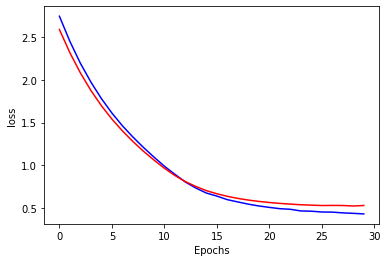

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history[0]["loss"], color="b")
plt.plot(history[0]["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

## Affichage du graphique pour voir l'intégralité de l'évolution de l'accuracy sur le train et le val.

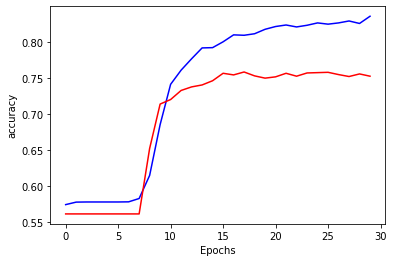

In [ ]:
# Visualization of the training process on the loss function 
plt.plot(history[0]["accuracy"], color="b")
plt.plot(history[0]["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# model.history.history

In [ ]:
model.evaluate(test_data)


35/35 [==============================] - 0s 9ms/step - loss: 0.5296 - accuracy: 0.7522


[0.5296469926834106, 0.7522441744804382]

#*** Sur la base de notre test, nous pouvons conclure que sur des données réelles, on a 75 % d'accuracy. Ce qui est amplement satisfaisant.***